# Prepare data for use with OpenSfM

In [115]:
import sys
import os
import glob
import json
import pickle
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../..")
from extractor.common import Capture
from extractor.mapping.gps import gps_to_ltp
from extractor.mapping.geotransforms import enu2geodetic

In [116]:
calibration_root = "../../calibration/parameters/ir"

work_dir = "/storage-2/pvextractor-georeferencing/20210510_Schmalenbach/workdir/devel"
gps_file = os.path.join(work_dir, "splitted", "gps", "gps.json")
frames_root = os.path.join(work_dir, "splitted")
cluster_idx = 0 #cluster["cluster_idx"]
frame_cluster = (0, 3750) #(cluster["frame_idx_start"], cluster["frame_idx_end"])
video_width = 640
video_height = 512
output_dir = os.path.join(work_dir, "mapping", "cluster_{:06d}".format(cluster_idx))
os.makedirs(output_dir, exist_ok=True)

### Prepare camera calibration file

In [118]:
camera_matrix = pickle.load(open(os.path.join(calibration_root, "camera_matrix.pkl"), "rb"))
dist_coeffs = pickle.load(open(os.path.join(calibration_root, "dist_coeffs.pkl"), "rb"))
k1, k2, p1, p2, k3 = dist_coeffs[0]

image_width = video_width  # px
image_height = video_height  # px
scale = np.maximum(image_width, image_height)
c_x = (camera_matrix[0, 2] - 0.5*image_width) / scale
c_y = (camera_matrix[1, 2] - 0.5*image_height) / scale

camera_models_overrides = {
    "all": {
        "projection_type": "brown",
        "width": image_width,
        "height": image_height,
        "focal_x": camera_matrix[0][0] / scale,
        "focal_y": camera_matrix[1][1] / scale,
        "c_x": c_x,
        "c_y": c_y,
        "k1": k1,
        "k2": k2,
        "k3": k3, 
        "p1": p1,
        "p2": p2
    }
}

print(camera_models_overrides)

json.dump(camera_models_overrides, open(os.path.join(output_dir, "camera_models_overrides.json"), "w"))

{'all': {'projection_type': 'brown', 'width': 640, 'height': 512, 'focal_x': 1.7497134950187117, 'focal_y': 1.7561354305878207, 'c_x': 0.0019185088959331686, 'c_y': 0.014137922203434617, 'k1': 0.3516947799358169, 'k2': 1.1245067331955985, 'k3': -3.2497961740262657, 'p1': 0.008548514777278604, 'p2': 0.003019085785903421}}


### Create config.yaml file

In [119]:
# copy settings from config file into dedicated yaml file and place into OpenSfM work directory
settings = {"matching_gps_distance": 20, "processes": 16}  # simulate settings being passed

yaml.dump(settings, open(os.path.join(output_dir, "config.yaml"), 'w'))

### Load GPS trajectory and convert from WGS-84 to ECEF

In [167]:
gps_ = json.load(open(gps_file, "r"))
gps_ = np.array(gps_[frame_cluster[0]:frame_cluster[1]])
if gps_.shape[-1] == 2:
    gps = np.zeros((len(gps_), 3))
    gps[:, 0:2] = gps_
else:
    gps = gps_
    gps[:, 2] -= np.min(gps[:, 2])
gps, origin = gps_to_ltp(gps)

### Linearly interpolate GPS trajectory

In [168]:
def interpolate_gps(gps):
    """Interpolates a piecewise constant gps signal with piecewise
    linear segments.
    
    This is needed because the GPS position acquiredby our drone is
    constant for several frames and then jumps abruptly. This 
    function smooths out the abrupt changes by linearly interpolating
    positions between the jumps.
    """
    
    # compute differences at steps, i.e. at the points where the GPS signal updates
    diffs = np.diff(gps, axis=0)
    
    # find indices where jumps occur
    update_idxs = np.where(np.abs(diffs[:, 0]) > 0)[0]
    update_idxs += 1
    update_idxs = np.insert(update_idxs, 0, 0)
    update_idxs = np.insert(update_idxs, len(update_idxs), len(gps)-1)
    
    # compute position incrementals to smoothen out jumps
    gps_diffs = []
    for i, (last_update_idx, update_idx) in enumerate(zip(update_idxs, update_idxs[1:])):       
        gps_diff = gps[update_idx] - gps[last_update_idx]
        n_steps = update_idx - last_update_idx
        for j in range(n_steps):
            gps_diffs.append(j*(gps_diff / n_steps))
    gps_diffs = np.array(gps_diffs)

    return gps[:-1, :] + gps_diffs

gps_interp = interpolate_gps(gps)

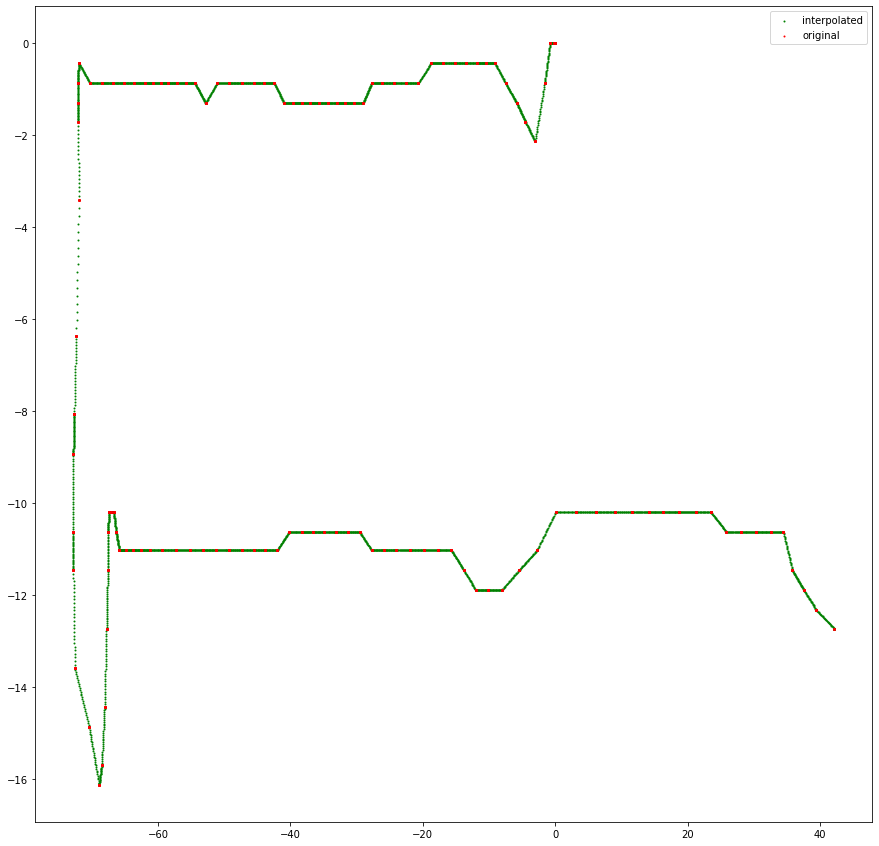

In [169]:
plt.figure(figsize=(15,15))
plt.scatter(gps_interp[:, 0], gps_interp[:, 1], s=1, c="g")
plt.scatter(gps[:, 0], gps[:, 1], s=1, c="r")
plt.legend(["interpolated", "original"])
plt.show()

### Select subset of frames based on travelled GPS distance

In [171]:
gps = gps_interp

In [155]:
# select based on distance along the trajectory to last selected frame
threshold = 1.0 # m
last_pos = np.zeros((2,))
selected_frames = [0]
travelled_distance = 0
for i in range(len(gps)):
    pos = gps[i, :2]
    travelled_distance += np.linalg.norm(pos - last_pos)
    last_pos = pos
    if travelled_distance > threshold:
        travelled_distance = 0
        selected_frames.append(i)
        
print(len(selected_frames))

202


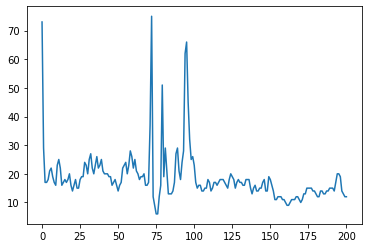

In [156]:
plt.plot(np.diff(selected_frames))

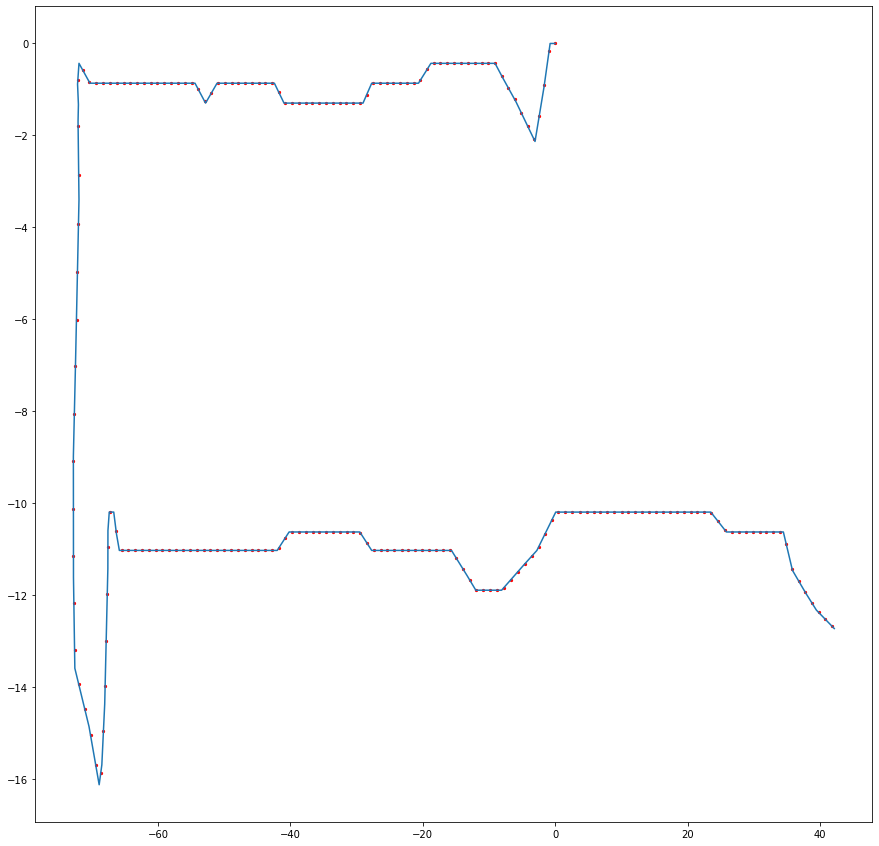

In [157]:
plt.figure(figsize=(15, 15))
plt.plot(gps[:, 0], gps[:, 1])
plt.scatter(gps[selected_frames, 0], gps[selected_frames, 1], c="r", s=5)
plt.show()

In [158]:
# get corresponding video frames
frame_files = sorted(glob.glob(os.path.join(frames_root, "radiometric", "*.tiff")))
frame_files = frame_files[frame_cluster[0]:frame_cluster[1]]
cap = Capture(frame_files, None, camera_matrix, dist_coeffs)

In [159]:
# write output video from selected frames for debugging
video_shape = (video_width, video_height)
output_video_fps = 5
video_path = os.path.join(output_dir, "selected_images.avi")
image_path = os.path.join(output_dir, "images")
fourcc = cv2.VideoWriter_fourcc(*"DIVX")
videowriter = cv2.VideoWriter(video_path, fourcc, output_video_fps, video_shape)
limit = None

os.makedirs(image_path, exist_ok=True)

frame_names = []
for i, selected_frame in enumerate(selected_frames[:limit]):
    frame, _, frame_name, _ = cap.get_frame(selected_frame, preprocess=True, undistort=True, equalize_hist=True)
    frame_names.append(frame_name)
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    videowriter.write(frame)
    cv2.imwrite(os.path.join(output_dir, "images", "{}.jpg".format(frame_name)), frame)
    
videowriter.release()

In [160]:
# Create output GPS file
use_altitude = True
exif_overrides = {}
for i, (selected_frame, frame_name) in enumerate(zip(selected_frames[:limit], frame_names[:limit])):
    pos = gps[selected_frame]
    lat, lon, alt = enu2geodetic(*pos, *origin)  # convert GPS from ECEF to WGS-84
    if not use_altitude:
        alt = 0.0
    exif_overrides["{}.jpg".format(frame_name)] = {
        "gps": {
            "latitude": lat,
            "longitude": lon,
            "altitude": alt,
            "dop": 0.1
            
        }
    }
json.dump(exif_overrides, open(os.path.join(output_dir, "exif_overrides.json"), "w"))